# 量化策略回测框架 - ConvLSTM模型集成 (V2 - 增加因子筛选)

In [23]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style, Back
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import pickle
from pathlib import Path
import warnings
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
import gc  # 用于内存管理
from scipy.stats import spearmanr # 仅用于验证，核心计算不再依赖
from tqdm import tqdm # 用于显示筛选进度

# 忽略Pandas在特定操作中可能产生的无害警告
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning) # 忽略在计算中可能遇到的RuntimeWarning

# 配置日志输出格式
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')

---
## 1. 新增：两阶段因子筛选模块

该模块实现了“质量指标初筛”和“回测表现精筛”的漏斗式筛选流程。

In [24]:
# --- MODIFIED: 修正并优化因子筛选模块 ---

def calculate_factor_metrics(factor_series, forward_returns, rolling_window=252):
    """
    计算单个因子的滚动Rank IC和IR (使用高效的Pandas惯用法)。
    
    参数:
    - factor_series (pd.Series): 单个因子的时间序列值。
    - forward_returns (pd.Series): 对齐的未来收益率序列。
    - rolling_window (int): 计算滚动指标的窗口大小。
    
    返回:
    - tuple: (平均Rank IC, 信息比率 IR)
    """
    # 对齐数据，去除NaN
    data = pd.concat([factor_series, forward_returns], axis=1).dropna()
    data.columns = ['factor', 'return']

    if len(data) < rolling_window:
        return 0.0, 0.0

    # --- FIX START: 使用最高效的Pandas惯用法计算滚动Rank IC ---
    # 步骤1: 分别计算因子和收益的滚动秩次
    # .rank(pct=True) 将值转换为0到1的百分位秩次
    ranked_factor = data['factor'].rolling(window=rolling_window).rank(pct=True)
    ranked_return = data['return'].rolling(window=rolling_window).rank(pct=True)
    
    # 步骤2: 计算滚动秩次的皮尔逊相关系数，这等价于斯皮尔曼相关系数
    # rolling().corr() 是高度优化的函数
    rolling_rank_ic = ranked_factor.rolling(window=rolling_window).corr(ranked_return)
    # --- FIX END ---
    
    # 计算平均Rank IC
    mean_rank_ic = rolling_rank_ic.mean()
    
    # 计算IR (信息比率)
    std_rank_ic = rolling_rank_ic.std()
    ir = mean_rank_ic / std_rank_ic if std_rank_ic > 0 and not np.isnan(std_rank_ic) else 0
    
    return mean_rank_ic, ir


In [25]:
def factor_to_signal(factor_series, upper_quantile=0.7, lower_quantile=0.3):
    """
    将连续的因子值转换为离散的交易信号 (1, -1, 0)。
    
    参数:
    - factor_series (pd.Series): 因子值序列。
    - upper_quantile (float): 做多信号的阈值分位数。
    - lower_quantile (float): 做空信号的阈值分位数。
    
    返回:
    - pd.Series: 交易信号序列。
    """
    upper_threshold = factor_series.quantile(upper_quantile)
    lower_threshold = factor_series.quantile(lower_quantile)
    
    signal = pd.Series(0, index=factor_series.index, dtype=np.int8)
    signal[factor_series > upper_threshold] = 1
    signal[factor_series < lower_threshold] = -1
    
    return signal

In [26]:
def _calculate_performance_metrics(backtest_results, trade_history, initial_capital, holding_period):
    """
    一个“静默”的性能计算函数，用于因子筛选，它返回指标值而不是打印报告。
    其核心计算逻辑严格遵循您提供的 `evaluate_realized_pnl_performance` 函数。
    """
    df = backtest_results
    trade_df = trade_history
    
    # 核心收益与风险指标
    total_return = (df['equity_curve'].iloc[-1] - initial_capital) / initial_capital
    equity_curve = df['equity_curve']
    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (peak - equity_curve) / peak
    max_drawdown = drawdown.max()
    
    # 年化指标
    duration_years = max((df.index[-1] - df.index[0]).days / 365.25, 0.001)
    annualized_return = total_return / duration_years
    
    # 标准化风险调整后收益
    monthly_returns = df['equity_curve'].resample('M').last().pct_change().dropna()
    sharpe_ratio = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12) if len(monthly_returns) > 1 else 0
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    # 交易统计
    total_trades = len(trade_df)
    expectancy = 0
    if total_trades > 0:
        winning_trades = trade_df[trade_df['net_pnl'] > 0]
        losing_trades = trade_df[trade_df['net_pnl'] <= 0]
        win_rate = len(winning_trades) / total_trades
        avg_win = winning_trades['net_pnl'].mean() / initial_capital if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['net_pnl'].mean() / initial_capital if len(losing_trades) > 0 else 0
        # 期望收益公式严格按照您提供的版本
        profit_factor = abs(winning_trades['net_pnl'].sum() / losing_trades['net_pnl'].abs().sum()) if len(losing_trades) > 0 and losing_trades['net_pnl'].abs().sum() > 0 else float('inf')
        # 修正期望收益公式以匹配您的定义
        # 您的定义：期望收益 = (胜率 * 盈亏比) - (1 - 胜率)
        # 注意：这个公式在金融领域不常见，但我们严格遵循您的要求。
        # 常见的公式是：(胜率 * 平均盈利) - (败率 * 平均亏损)
        # 我们将使用您提供的公式：
        expectancy_from_formula = (win_rate * profit_factor) - (1 - win_rate) if profit_factor != float('inf') else float('inf')
    else:
        expectancy_from_formula = 0

    # 效率指标
    weekly_trades = trade_df.resample('W', on='entry_time').size().mean() if not trade_df.empty else 0
    
    return {
        "sharpe_ratio": sharpe_ratio,
        "calmar_ratio": calmar_ratio,
        "max_drawdown": max_drawdown,
        "expectancy": expectancy_from_formula,
        "weekly_trades": weekly_trades
    }

In [27]:
def screen_factors_sequentially(factor_data, config):
    """
    执行完整的两阶段漏斗式因子筛选。
    """
    logging.info("===== 开始执行两阶段因子筛选流程 =====")
    
    all_factor_cols = [col for col in factor_data.columns if col.startswith('ret') or col.startswith('c_chu') or col.startswith('c_hide')]
    prices = factor_data['close']
    
    logging.info(f"--- 阶段一：基于Rank IC和IR进行初筛 (共 {len(all_factor_cols)} 个因子) ---")
    
    forward_returns = prices.pct_change(config['holding_period']).shift(-config['holding_period'])
    
    passed_first_stage = []
    
    for factor_name in tqdm(all_factor_cols, desc="阶段一筛选进度"):
        factor_series = factor_data[factor_name]
        # 此处是关键，它需要 config['rolling_window']
        rank_ic, ir = calculate_factor_metrics(factor_series, forward_returns, rolling_window=config['rolling_window'])
        
        if abs(rank_ic) > config['rank_ic_threshold'] and abs(ir) > config['ir_threshold']:
            passed_first_stage.append(factor_name)
            
    logging.info(f"✅ 阶段一完成: {len(passed_first_stage)} / {len(all_factor_cols)} 个因子通过初筛。")
    
    if not passed_first_stage:
        logging.warning("⚠️ 没有任何因子通过第一阶段筛选，流程终止。")
        return [], []

    logging.info(f"--- 阶段二：基于单因子回测表现进行精筛 (共 {len(passed_first_stage)} 个因子) ---")
    
    final_selected_factors = []
    
    for factor_name in tqdm(passed_first_stage, desc="阶段二筛选进度"):
        factor_signal = factor_to_signal(factor_data[factor_name])
        
        backtest_results, trade_history = run_realized_pnl_backtest(
            prices=prices,
            signals=factor_signal,
            initial_capital=config['initial_capital'],
            commission_rate=config['commission_rate'],
            holding_period=config['holding_period']
        )
        
        if trade_history.empty:
            continue
            
        perf = _calculate_performance_metrics(
            backtest_results, 
            trade_history, 
            config['initial_capital'],
            config['holding_period']
        )
        
        returns_ok = (perf['sharpe_ratio'] > config['sharpe_threshold'] and perf['calmar_ratio'] > config['calmar_threshold']) or \
                     (perf['expectancy'] > config['expectancy_threshold'])
        
        risk_ok = perf['max_drawdown'] < config['mdd_threshold']
        
        efficiency_ok = perf['weekly_trades'] > config['weekly_trades_threshold']
        
        if returns_ok and risk_ok and efficiency_ok:
            final_selected_factors.append(factor_name)
            logging.debug(f"  -> ✅ 因子 '{factor_name}' 通过精筛. Sharpe: {perf['sharpe_ratio']:.2f}, MDD: {perf['max_drawdown']:.2%}")
        else:
            logging.debug(f"  -> ❌ 因子 '{factor_name}' 未通过精筛. Sharpe: {perf['sharpe_ratio']:.2f}, MDD: {perf['max_drawdown']:.2%}")

    logging.info(f"✅ 阶段二完成: {len(final_selected_factors)} / {len(passed_first_stage)} 个因子通过精筛。")
    logging.info("===== 因子筛选流程结束 =====")
    
    return final_selected_factors, passed_first_stage

---
## 2. ConvLSTM模型构建与训练

In [28]:
def build_enhanced_conv_lstm_model(input_shape, num_features):
    """
    构建增强版ConvLSTM混合模型架构，处理更多因子
    
    模型增强点:
    1. 增加卷积层通道数和LSTM单元数
    2. 添加双向LSTM捕捉更复杂的时序依赖
    3. 引入注意力机制聚焦重要特征
    4. 增加残差连接深度
    
    参数:
    - input_shape: 输入数据形状 (时间步长, 特征数)
    - num_features: 特征数量
    
    返回:
    - 编译好的Keras模型
    """
    from tensorflow.keras.layers import Bidirectional, Attention, Reshape
    
    # 输入层
    inputs = Input(shape=input_shape)
    
    # 1. 特征提取分支
    # 1D卷积分支 - 提取局部特征模式
    conv1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.3)(conv1)
    
    conv2 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.3)(conv2)
    
    # 2. 时序依赖分支
    # 双向LSTM捕捉复杂时序模式
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm1 = BatchNormalization()(lstm1)
    lstm1 = Dropout(0.3)(lstm1)
    
    # 注意力机制聚焦重要时间步
    attention = Attention()([lstm1, lstm1])
    lstm2 = Bidirectional(LSTM(256, return_sequences=False))(attention)
    lstm2 = BatchNormalization()(lstm2)
    lstm2 = Dropout(0.4)(lstm2)
    
    # 3. 合并分支
    conv_flat = Flatten()(conv2)
    merged = concatenate([conv_flat, lstm2])
    
    # 4. 全连接层
    dense1 = Dense(512, activation='relu')(merged)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(256, activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.4)(dense2)
    
    # 5. 输出层 - 三分类(做多/做空/中性)
    outputs = Dense(3, activation='softmax')(dense2)
    
    # 创建模型
    model = Model(inputs=inputs, outputs=outputs)
    
    # 编译模型
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [29]:
def prepare_rolling_data(factor_data, selected_features, lookback=60, test_size=0.2):
    """
    准备滚动训练数据 - 使用筛选后的精英因子 (已修正索引错误)
    """
    logging.info("📊 准备滚动训练数据 (使用筛选后的精英因子)...")
    
    feature_columns = selected_features
    
    if not feature_columns:
        raise ValueError("错误：没有可用的特征。因子筛选后列表为空。")
        
    logging.info(f"✅ 使用 {len(feature_columns)} 个精英因子特征")
    
    # --- FIX: 使用推荐的 ffill() ---
    features = factor_data[feature_columns].ffill().fillna(0)
    
    # 创建目标变量
    future_returns = np.log(factor_data['close']).diff(10).shift(-10)
    volatility = future_returns.rolling(100).std().fillna(0.01)
    upper_threshold = 0.75 * volatility
    lower_threshold = -0.75 * volatility
    
    # 创建一个临时的1D Series用于对齐
    y_series = pd.Series(0, index=factor_data.index)
    y_series[future_returns > upper_threshold] = 1
    y_series[future_returns < lower_threshold] = 2
    
    # --- FIX START: 修正核心对齐逻辑 ---
    
    # 1. 先将特征和1D的y_series对齐，得到正确的索引
    aligned_features, aligned_y_series = features.align(y_series, join='inner', axis=0)
    
    # 2. 使用对齐后的索引，从原始的factor_data中重新计算一个完全对齐的y，并转换为分类格式
    # 这样可以确保y_categorical与aligned_features的行一一对应
    aligned_y_categorical = tf.keras.utils.to_categorical(aligned_y_series.values, num_classes=3)

    # 3. 现在，aligned_features 和 aligned_y_categorical 是完全同步的
    
    # 特征选择与降维
    k_best = min(100, len(feature_columns))
    selector = SelectKBest(f_classif, k=k_best)
    features_selected = selector.fit_transform(aligned_features, aligned_y_series)
    
    pca = PCA(n_components=0.95)
    features_reduced = pca.fit_transform(features_selected)
    
    logging.info(f"✅ 降维后特征数: {features_reduced.shape[1]}")
    
    # 创建时间序列样本
    X = []
    valid_indices = []
    
    for i in range(lookback, len(features_reduced) - 10):
        X.append(features_reduced[i-lookback:i])
        valid_indices.append(i)
    
    X = np.array(X)
    
    # 4. 现在可以安全地使用整数列表 valid_indices 来索引已经对齐好的数据
    y = aligned_y_categorical[valid_indices]
    indices = aligned_features.index[valid_indices]
    
    # --- FIX END ---
    
    logging.info(f"✅ 数据准备完成 - 样本数: {X.shape[0]}, 时间步长: {X.shape[1]}, 特征数: {X.shape[2]}")
    return X, y, indices, pca, selector

In [30]:
def rolling_train_and_predict(X, y, indices, lookback=60, n_splits=5):
    """
    执行滚动训练和预测 (增强版)
    
    增强点:
    1. 使用增强版模型
    2. 更早停止和动态学习率调整
    3. 更精细的信号处理
    
    参数:
    - X: 特征数据
    - y: 标签数据
    - indices: 时间索引
    - lookback: 回看时间步长
    - n_splits: 时间序列分割数
    
    返回:
    - 预测信号Series
    """
    logging.info(f"🚀 开始滚动训练 (n_splits={n_splits})...")
    
    # 初始化预测结果数组
    all_predictions = np.zeros((len(y), 3))
    
    # 创建时间序列交叉验证器
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # 用于存储每个折叠的性能
    fold_accuracies = []
    fold_losses = []
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        logging.info(f"\n🔁 处理折叠 {fold+1}/{n_splits}")
        logging.info(f"  训练集: {indices[train_index[0]]} 到 {indices[train_index[-1]]}")
        logging.info(f"  测试集: {indices[test_index[0]]} 到 {indices[test_index[-1]]}")
        
        # 划分训练集和测试集
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # 标准化 - 使用训练集的统计量
        scaler = StandardScaler()
        X_train_2d = X_train.reshape(-1, X_train.shape[-1])
        X_test_2d = X_test.reshape(-1, X_test.shape[-1])
        
        scaler.fit(X_train_2d)
        X_train_scaled = scaler.transform(X_train_2d).reshape(X_train.shape)
        X_test_scaled = scaler.transform(X_test_2d).reshape(X_test.shape)
        
        # 构建增强版模型
        model = build_enhanced_conv_lstm_model((lookback, X_train.shape[2]), X_train.shape[2])
        
        # 回调函数 - 更早停止和动态学习率
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
        ]
        
        # 训练模型 - 增加epochs
        history = model.fit(
            X_train_scaled, y_train,
            epochs=50,
            batch_size=1024,
            validation_data=(X_test_scaled, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        # 在测试集上预测
        test_pred = model.predict(X_test_scaled, batch_size=2048, verbose=0)
        all_predictions[test_index] = test_pred
        
        # 评估性能
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
        fold_accuracies.append(test_acc)
        fold_losses.append(test_loss)
        logging.info(f"  测试准确率: {test_acc:.4f}, 测试损失: {test_loss:.4f}")
        
        # 清理内存
        del model, X_train, X_test, y_train, y_test
        gc.collect()
        tf.keras.backend.clear_session()
    
    # 打印整体性能
    logging.info(f"\n✅ 滚动训练完成 - 平均准确率: {np.mean(fold_accuracies):.4f}, 平均损失: {np.mean(fold_losses):.4f}")
    
    # 转换预测结果为信号
    signal_probs = all_predictions[:, 1] - all_predictions[:, 2]  # 做多概率 - 做空概率
    
    # 创建信号Series
    signal_series = pd.Series(signal_probs, index=indices, name='signal_strength')
    
    # 使用动态阈值生成交易信号
    rolling_mean = signal_series.rolling(window=100).mean()
    rolling_std = signal_series.rolling(window=100).std()
    
    # 动态阈值
    long_threshold = rolling_mean + 0.5 * rolling_std
    short_threshold = rolling_mean - 0.5 * rolling_std
    
    # 生成最终信号
    signals = pd.Series(0, index=indices)
    signals[signal_series > long_threshold] = 1
    signals[signal_series < short_threshold] = -1
    
    # 信号平滑 - 避免频繁变动
    signals = signals.rolling(window=5, min_periods=3).mean()
    signals = np.where(signals > 0.3, 1, np.where(signals < -0.3, -1, 0))
    
    signal_series = pd.Series(signals, index=indices)
    
    logging.info(f"📡 信号生成完成 - 做多比例: {(signal_series == 1).mean():.2%}, "
                 f"做空比例: {(signal_series == -1).mean():.2%}")
    
    return signal_series

## 3. 核心回测与评估函数 (保持不变)
(此处保留原有的run_realized_pnl_backtest和evaluate_realized_pnl_performance函数)

In [31]:
def run_realized_pnl_backtest(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    执行基于已实现盈亏的高性能回测。

    本函数为回测框架的核心，其设计严格遵循以下交易逻辑：
    1. **资金管理**: 初始资金被等分为10份，每次开仓使用一份，用于模拟分批建仓。
    2. **单向持仓**: 在任何时间点，所有持仓的方向必须一致（全为多头或全为空头），不允许锁仓或同时持有多空。
    3. **事件驱动**: 交易信号在t-1时刻产生，在t时刻执行。
    4. **固定持有期**: 每份独立的仓位最多持有`holding_period`个周期，到期后自动平仓。
    5. **渐进式调仓**: 当收到与当前持仓方向相反的信号时，仅平掉**最早开立**的一份仓位，而非全部平仓，以实现更平滑的调仓，减少交易冲击。
    6. **已实现盈亏**: 权益曲线的计算完全基于已关闭仓位的真实盈亏，忽略未平仓位的浮动盈亏，使结果更保守稳健。

    性能优化关键点:
    - **预分配数组**: 使用NumPy数组预先分配内存来存储回测结果，避免在循环中动态修改Pandas DataFrame，这是主要的性能提升来源。
    - **高效队列操作**: 利用`collections.deque`的O(1)时间复杂度的`popleft()`和`append()`操作管理活跃仓位。
    - **算法优化**: 检查到期仓位时，仅需检查队列头部的最早仓位，无需遍历整个队列。

    参数:
    - prices (pd.Series): 资产的收盘价序列。
    - signals (pd.Series): 交易信号序列 (1: 做多, -1: 做空, 0: 中性)。
    - initial_capital (float): 初始总资本。
    - commission_rate (float): 单边交易手续费率。
    - holding_period (int): 每份仓位的最大持有周期（单位：K线数量）。

    返回:
    - pd.DataFrame: 包含回测详细过程（如持仓、成本、权益等）的DataFrame。
    - pd.DataFrame: 包含每一笔已完成交易的详细历史记录。
    """
    logging.info("🚀 开始执行优化版回测 (基于已实现盈亏)...")

    n = len(prices)
    # --- 性能优化: 预分配结果存储 ---
    # 将结果存储在字典包裹的NumPy数组中，循环结束后一次性生成DataFrame。
    # 这比在循环中逐行填充DataFrame（如使用.at或.loc）快几个数量级。
    results = {
        'position': np.zeros(n, dtype=np.int8),
        'position_count': np.zeros(n, dtype=np.int8),
        'cost_basis': np.zeros(n),
        'transaction_costs': np.zeros(n),
        'net_returns': np.zeros(n),
        'equity_curve': np.full(n, initial_capital)
    }

    # --- 性能优化: 预提取数据到NumPy数组 ---
    # 在循环开始前将Pandas Series转换为NumPy数组，后续在循环中访问数组元素比访问Series元素更快。
    close_arr = prices.values
    signal_arr = signals.values
    indices = prices.index # 预存索引，用于记录交易历史

    # --- 初始化交易状态变量 ---
    active_positions = deque()  # 使用双端队列(deque)高效管理先进先出的持仓
    realized_pnl = 0.0          # 累计已实现盈亏
    position_direction = 0      # 当前整体持仓方向 (1: 多, -1: 空, 0: 无)
    position_cost = 0.0         # 当前持仓的平均成本价
    trade_history = []          # 记录每一笔完整交易的列表
    capital_per_position = initial_capital / 10 # 每份仓位分配的资金

    # --- 主回测循环 ---
    # 从第二个时间点开始遍历，因为交易决策基于前一天的信号
    for i in range(1, n):
        current_close = close_arr[i]
        prev_signal = signal_arr[i-1]  # 使用t-1的信号决定t时刻的操作
        trades_occurred = False        # 标记当日是否有交易（平仓）发生

        # 1. 处理到期强制平仓
        # --- 性能优化: O(1)复杂度的到期检查 ---
        # 由于active_positions是先进先出队列，我们只需检查队头（最早的仓位）。
        # 如果队头没到期，那么队列中所有其他仓位也一定没到期。
        while active_positions:
            oldest_pos = active_positions[0] # 只看不取
            if i - oldest_pos['entry_index'] >= holding_period:
                # 仓位已到期，执行平仓
                pos_to_close = active_positions.popleft() # 从队列中移除
                exit_price = current_close
                
                # 计算盈亏
                pnl = (exit_price - pos_to_close['entry_price']) * pos_to_close['direction'] * pos_to_close['quantity']
                exit_commission = commission_rate * exit_price * pos_to_close['quantity']
                net_pnl = pnl - exit_commission
                
                # 更新累计已实现盈亏
                realized_pnl += net_pnl
                trades_occurred = True
                
                # 记录交易成本
                results['transaction_costs'][i] += exit_commission
                
                # 记录交易历史
                trade_history.append({
                    'entry_time': indices[pos_to_close['entry_index']], 'exit_time': indices[i],
                    'direction': pos_to_close['direction'], 'entry_price': pos_to_close['entry_price'],
                    'exit_price': exit_price, 'quantity': pos_to_close['quantity'],
                    'pnl': pnl, 'commission': exit_commission, 'net_pnl': net_pnl,
                    'duration': i - pos_to_close['entry_index'], 'type': 'expired'
                })
            else:
                # 最早的仓位都未到期，则无需继续检查
                break

        # 2. 根据新信号处理交易
        if prev_signal != 0:  # 只对非中性信号做出反应
            # 情况A: 当前无任何持仓，且有新信号
            if position_direction == 0:
                # 开立第一份仓位
                quantity = capital_per_position / current_close
                active_positions.append({
                    'direction': prev_signal,
                    'entry_price': current_close,
                    'quantity': quantity,
                    'entry_index': i
                })
                position_direction = prev_signal
                position_cost = current_close
                entry_commission = commission_rate * current_close * quantity
                results['transaction_costs'][i] += entry_commission
                results['position'][i] = prev_signal

            # 情况B: 新信号与当前持仓方向相同 (加仓)
            elif position_direction == prev_signal and len(active_positions) < 10:
                # 如果仓位未满10份，则加开一份新仓
                quantity = capital_per_position / current_close
                active_positions.append({
                    'direction': prev_signal, 'entry_price': current_close,
                    'quantity': quantity, 'entry_index': i
                })
                # 更新平均持仓成本
                total_quantity = sum(p['quantity'] for p in active_positions)
                total_cost = sum(p['entry_price'] * p['quantity'] for p in active_positions)
                position_cost = total_cost / total_quantity
                entry_commission = commission_rate * current_close * quantity
                results['transaction_costs'][i] += entry_commission
                results['position'][i] = prev_signal

            # 情况C: 新信号与当前持仓方向相反 (部分平仓)
            elif position_direction != prev_signal and active_positions:
                # 核心逻辑：只平掉最早的一份仓位，实现渐进式调仓
                pos_to_close = active_positions.popleft()
                exit_price = current_close
                pnl = (exit_price - pos_to_close['entry_price']) * pos_to_close['direction'] * pos_to_close['quantity']
                exit_commission = commission_rate * exit_price * pos_to_close['quantity']
                net_pnl = pnl - exit_commission

                realized_pnl += net_pnl
                trades_occurred = True
                results['transaction_costs'][i] += exit_commission

                trade_history.append({
                    'entry_time': indices[pos_to_close['entry_index']], 'exit_time': indices[i],
                    'direction': pos_to_close['direction'], 'entry_price': pos_to_close['entry_price'],
                    'exit_price': exit_price, 'quantity': pos_to_close['quantity'],
                    'pnl': pnl, 'commission': exit_commission, 'net_pnl': net_pnl,
                    'duration': i - pos_to_close['entry_index'], 'type': 'signal'
                })

                # 更新持仓状态
                if active_positions:
                    # 如果平仓后仍有持仓，重新计算平均成本
                    total_quantity = sum(p['quantity'] for p in active_positions)
                    total_cost = sum(p['entry_price'] * p['quantity'] for p in active_positions)
                    position_cost = total_cost / total_quantity
                else:
                    # 如果所有仓位都已平掉，重置持仓状态
                    position_direction = 0
                    position_cost = 0.0
                results['position'][i] = position_direction

        # 3. 更新每日状态
        results['position_count'][i] = len(active_positions)
        results['cost_basis'][i] = position_cost
        results['equity_curve'][i] = initial_capital + realized_pnl # 权益曲线仅随已实现盈亏变化

        # 4. 计算当日净收益率 (仅在有平仓交易时发生变化)
        if i > 0: # 从第二天开始计算
            prev_equity = results['equity_curve'][i-1]
            if trades_occurred:
                results['net_returns'][i] = (results['equity_curve'][i] - prev_equity) / prev_equity
            # 如果没有交易，净收益为0，数组默认就是0，无需操作

    # --- 回测期末处理 ---
    # 将所有剩余的未平仓头寸在最后一个交易日强制平仓
    if active_positions:
        last_close = close_arr[-1]
        for pos in active_positions:
            exit_price = last_close
            pnl = (exit_price - pos['entry_price']) * pos['direction'] * pos['quantity']
            exit_commission = commission_rate * exit_price * pos['quantity']
            net_pnl = pnl - exit_commission
            realized_pnl += net_pnl
            results['transaction_costs'][-1] += exit_commission

            trade_history.append({
                'entry_time': indices[pos['entry_index']],
                'exit_time': indices[-1],
                'direction': pos['direction'],
                'entry_price': pos['entry_price'],
                'exit_price': exit_price,
                'quantity': pos['quantity'],
                'pnl': pnl,
                'commission': exit_commission,
                'net_pnl': net_pnl,
                'duration': n - 1 - pos['entry_index'],
                'type': 'forced_close'
            })
            
        # 更新最终的权益和收益率
        results['equity_curve'][-1] = initial_capital + realized_pnl
        prev_equity = results['equity_curve'][-2] if n > 1 else initial_capital
        results['net_returns'][-1] = (results['equity_curve'][-1] - prev_equity) / prev_equity

    # --- 整合结果 ---
    # 使用预先计算好的NumPy数组，一次性创建最终的DataFrame
    df = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': results['position'],
        'position_count': results['position_count'],
        'cost_basis': results['cost_basis'],
        'transaction_costs': results['transaction_costs'],
        'net_returns': results['net_returns'],
        'equity_curve': results['equity_curve']
    }, index=prices.index)

    logging.info("✅ 优化版回测完成。")
    return df, pd.DataFrame(trade_history)

In [32]:
def evaluate_realized_pnl_performance(backtest_results, trade_history, initial_capital):
    """
    全面评估基于已实现盈亏的策略表现，并生成标准化报告。

    关键评估逻辑:
    - **标准化指标**: 夏普比率等关键风险指标基于月度收益率计算，以提供更稳健、更具可比性的评估。
    - **向量化计算**: 尽可能使用Pandas和NumPy的向量化功能，以提高计算效率。
    - **精确交易统计**: 所有交易相关指标（胜率、盈亏比等）均基于`trade_history` DataFrame进行精确计算。
    - **可视化报告**: 生成清晰的权益曲线图和多维度、格式化的性能指标表格。
    """
    logging.info("📊 开始进行全面的策略性能评估...")

    df = backtest_results.copy()
    trade_df = trade_history.copy()

    # --- 1. 核心收益与风险指标 ---
    final_equity = df['equity_curve'].iloc[-1]
    total_return = (final_equity - initial_capital) / initial_capital

    # 向量化计算回撤 (Drawdown)
    equity_curve = df['equity_curve']
    peak = equity_curve.expanding(min_periods=1).max() # 计算滚动最高点
    drawdown = (peak - equity_curve) / peak            # 计算回撤百分比
    max_drawdown = drawdown.max()                      # 获取最大回撤
    
    # 找到最大回撤
    mdd_end = drawdown.idxmax() if not drawdown.empty else None # 最大回撤结束点
    mdd_start = peak[:mdd_end].idxmax() if mdd_end is not None else None # 最大回撤开始点

    # 计算年化指标
    total_days = (df.index[-1] - df.index[0]).days
    duration_years = max(total_days / 365.25, 0.001)  # 避免除以零，最短为0.001年
    annualized_return = total_return / duration_years

    # --- 2. 标准化风险调整后收益 (Standardized Risk-Adjusted Metrics) ---
    # 关键修正：为遵循行业稳健标准，避免高频数据对指标的扭曲，
    # 夏普比率等指标应基于频率较低（如月度）的收益率计算。
    monthly_returns = df['equity_curve'].resample('M').last().pct_change().dropna()

    # 夏普比率 (Sharpe Ratio)
    # 公式: 年化(月度平均收益 / 月度收益标准差)
    sharpe_ratio = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12) if len(monthly_returns) > 1 else 0

    # 卡玛比率 (Calmar Ratio)
    # 公式: 年化收益率 / 最大回撤
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    # 年化波动率 (基于日净收益率计算)
    annualized_volatility = df['net_returns'].std() * np.sqrt(365.25) # 假设一年有365.25个交易日

    # --- 3. 交易统计 (基于精确的交易历史) ---
    total_trades = len(trade_df)
    if total_trades > 0:
        winning_trades = trade_df[trade_df['net_pnl'] > 0]
        losing_trades = trade_df[trade_df['net_pnl'] <= 0]

        win_rate = len(winning_trades) / total_trades
        # 平均盈/亏计算的是占初始资本的百分比
        avg_win = winning_trades['net_pnl'].mean() / initial_capital if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['net_pnl'].mean() / initial_capital if len(losing_trades) > 0 else 0
        # 盈亏比
        profit_factor = abs(winning_trades['net_pnl'].sum() / losing_trades['net_pnl'].abs().sum()) if len(losing_trades) > 0 and losing_trades['net_pnl'].abs().sum() > 0 else float('inf')
        # 期望收益
        expectancy = (win_rate * avg_win) + ((1 - win_rate) * avg_loss)
    else:
        # 如果没有交易，所有指标设为0
        win_rate = avg_win = avg_loss = profit_factor = expectancy = 0

    # --- 4. 其他辅助指标 ---
    # 持仓比例 (向量化计算)
    long_ratio = (df['position'] > 0).mean()
    short_ratio = (df['position'] < 0).mean()

    # 每周开仓频率
    weekly_trades = trade_df.resample('W', on='entry_time').size().mean() if not trade_df.empty else 0

    # 年化换手率 (Annualized Turnover)
    if total_trades > 0:
        # 名义本金 = 价格 * 数量
        trade_df['entry_notional'] = trade_df['entry_price'] * trade_df['quantity']
        trade_df['exit_notional'] = trade_df['exit_price'] * trade_df['quantity']
        # 总交易额 = (买入总额 + 卖出总额) / 2
        total_turnover = (trade_df['entry_notional'].sum() + trade_df['exit_notional'].sum()) / 2
        avg_net_assets = df['equity_curve'].mean()
        # 年化换手率 = (总交易额 / 平均净资产) / 年数
        annualized_turnover = (total_turnover / avg_net_assets) / duration_years
    else:
        annualized_turnover = 0

    # 信息系数 (Information Coefficient, IC)
    # 衡量信号对下一期收益的预测能力
    forward_returns = df['close'].pct_change().shift(-1)
    # 确保信号和未来收益对齐，且无空值
    valid_idx = df['signal'].shift(1).notna() & forward_returns.notna()
    ic = np.corrcoef(df['signal'].shift(1)[valid_idx], forward_returns[valid_idx])[0, 1]

    # 逐年收益率
    yearly_returns = []
    for year, group in df.groupby(df.index.year):
        if len(group) > 1:
            start_equity = group['equity_curve'].iloc[0]
            end_equity = group['equity_curve'].iloc[-1]
            yearly_return = (end_equity - start_equity) / start_equity
            yearly_returns.append((year, yearly_return))

    # --- 5. 基准计算 ---
    # 理论基准: 完美预测下的理论收益 (信号 * 未来10期收益)，用于衡量信号质量
    future_return = (df['close'].shift(-10) - df['close']) / df['close']
    # 乘以0.1是因为策略每次只投入1/10的资金
    theoretical_benchmark = (df['signal'].shift(1) * future_return * 0.1).fillna(0).cumsum()
    strategy_cumulative = (df['equity_curve'] - initial_capital) / initial_capital
    correlation = strategy_cumulative.corr(theoretical_benchmark)

    # 买入并持有基准 (Buy & Hold)
    buy_hold_curve = initial_capital * (df['close'] / df['close'].iloc[0])

    # --- 6. 生成格式化报告 ---
    print("\n" + "=" * 80)
    print(Fore.CYAN + Style.BRIGHT + " " * 30 + "策略性能评估报告" + " " * 30 + Style.RESET_ALL)
    print("=" * 80)
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    detail_headers = ["指标名称", "计算结果", "要求", "状态"]
    
    sharpe_status = "✅ 达标" if sharpe_ratio >= 2.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    calmar_status = "✅ 达标" if calmar_ratio >= 5.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    expectancy_status = "✅ 达标" if expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    
    detail_table = [
        ["夏普比率 (Sharpe)", f"{sharpe_ratio:.4f}", "> 2.0", sharpe_status],
        ["卡玛比率 (Calmar)", f"{calmar_ratio:.4f}", "> 5.0", calmar_status],
        ["期望收益 (Expectancy)", f"{expectancy:.4f}", "> 0.25", expectancy_status]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "策略方案评估" + Style.RESET_ALL)
    scheme_table = [
        ["方案一 (夏普 & 卡玛)", "✅ 达标" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["方案二 (期望收益)", "✅ 达标" if expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合收益指标", "✅ 达标" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 and expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print(tabulate(scheme_table, headers=["策略方案", "状态"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "持仓统计" + Style.RESET_ALL)
    position_table = [
        ["多头持仓占比", f"{long_ratio:.2%}"],
        ["空头持仓占比", f"{short_ratio:.2%}"]
    ]
    print(tabulate(position_table, headers=["指标", "值"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    risk_headers = ["指标名称", "计算结果", "要求", "状态"]
    mdd_status = "✅ 达标" if max_drawdown < 0.2 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    trade_freq_status = "✅ 达标" if weekly_trades > 5 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    
    risk_table = [
        ["最大回撤 (MDD)", f"{max_drawdown:.3%}", "< 0.2", mdd_status],
        ["每周开仓频率", f"{weekly_trades:.4f}", "> 5", trade_freq_status]
    ]
    print(tabulate(risk_table, headers=risk_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.YELLOW + Style.BRIGHT + "综合指标评估" + Style.RESET_ALL)
    risk_summary_table = [
        ["综合风控指标", "✅ 达标" if max_drawdown < 0.2 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合效率指标", "✅ 达标" if weekly_trades > 5 else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print(tabulate(risk_summary_table, headers=["指标", "状态"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    detailed_headers = ["指标名称", "值"]
    detailed_table = [
        [Fore.YELLOW + "与'signal × return'基准的相关性" + Style.RESET_ALL, f"{correlation:.3%}"],
        ["总收益率 (Total Return)", f"{total_return:.3%}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.3%}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.3%}"],
        ["总盈亏 (Total PnL)", f"${final_equity - initial_capital:,.2f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["盈利交易笔数 (Winning Trades)", f"{len(winning_trades)}"],
        ["亏损交易笔数 (Losing Trades)", f"{len(losing_trades)}"],
        ["胜率 (Win Rate)", f"{win_rate:.3%}"],
        ["盈亏比 (Profit Factor)", f"{profit_factor:.3f}"],
        ["平均盈利 (Average Win)", f"{avg_win:.3%}"],
        ["平均亏损 (Average Loss)", f"{avg_loss:.3%}"],
        ["年化换手率 (Annualized Turnover)", f"{annualized_turnover:.3%}"],
        ["最大回撤起始日期", f"{mdd_start}"],
        ["最大回撤结束日期", f"{mdd_end}"],
        ["信息系数 (IC)", f"{ic:.3f}"]
    ]
    print(tabulate(detailed_table, headers=detailed_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " 逐年收益率 " + "="*30 + Style.RESET_ALL)
    yearly_table = []
    for year, return_val in yearly_returns:
        yearly_table.append([year, f"{return_val:.3%}"])
    print(tabulate(yearly_table, headers=["年份", "收益率"], tablefmt="grid", stralign="center", numalign="center"))

    # --- 7. 绘制权益曲线图 ---
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # 仅在有交易发生时绘制垂直线条
    trade_dates = trade_df['exit_time'].unique()
    trade_dates = sorted(trade_dates)
    
    # 绘制阶梯状的策略权益曲线
    prev_equity = initial_capital
    for date in trade_dates:
        equity = df.loc[date, 'equity_curve']
        # 绘制水平线（前一点到当前点）
        prev_date = df.index[df.index.get_loc(date) - 1] if date != df.index[0] else date
        ax.hlines(y=prev_equity, xmin=prev_date, xmax=date, color='royalblue', linewidth=2)
        # 绘制垂直线（当前点）
        ax.vlines(x=date, ymin=prev_equity, ymax=equity, color='royalblue', linewidth=2)
        prev_equity = equity
    
    # 绘制最后一段
    last_trade_date = trade_dates[-1] if trade_dates else df.index[0]
    ax.hlines(y=prev_equity, xmin=last_trade_date, xmax=df.index[-1], color='royalblue', linewidth=2)
    
    # 绘制策略权益曲线 (使用阶梯图)
    # 阶梯图(step plot)能完美展示已实现盈亏曲线的特性：权益只在交易平仓时发生阶跃式变化。
    ax.step(df.index, df['equity_curve'], where='post', label='Strategy Equity', color='royalblue', linewidth=2)

    # 绘制理论基准曲线
    theoretical_curve = initial_capital * (1 + theoretical_benchmark)
    ax.plot(df.index, theoretical_curve, label='Theoretical Benchmark (signal×return)', color='purple', linestyle='--', alpha=0.7)

    # 绘制买入并持有基准曲线
    ax.plot(df.index, buy_hold_curve, label='Buy & Hold BTC', color='darkorange', linestyle=':', alpha=0.7)

    # 设置图表标题和标签
    ax.set_title('Strategy Equity Curve vs. Benchmarks (Realized PnL Only)', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Net Asset Value', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    logging.info("✅ 策略评估报告生成完毕。")

---
## 4. 主程序执行 (更新)

2025-08-07 23:25:04,675 - INFO - 🔧 TensorFlow已配置为使用最多 16 个 intra-op 核心和 4 个 inter-op 核心。
2025-08-07 23:25:04,677 - INFO - 📂 从 /public/data/factor_data/BTCUSDT_15m_2020_2025_factor_data.pkl 加载因子数据...
/tmp/ipykernel_1719099/3673494492.py:45: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  factor_data = pickle.load(f)
2025-08-07 23:25:04,747 - INFO - ✅ 数据加载成功 - 形状: (128448, 141)
2025-08-07 23:25:04,748 - INFO - 📅 时间范围: 2021-10-01 00:00:00 至 2025-05-30 23:45:00
2025-08-07 23:25:04,749 - INFO - ===== 开始执行两阶段因子筛选流程 ===

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3667 - loss: 1.7355 - val_accuracy: 0.1989 - val_loss: 1.4392 - learning_rate: 5.0000e-04
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4027 - loss: 1.3333 - val_accuracy: 0.2194 - val_loss: 1.2776 - learning_rate: 5.0000e-04
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4447 - loss: 1.2230 - val_accuracy: 0.3296 - val_loss: 1.0981 - learning_rate: 5.0000e-04
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4799 - loss: 1.1350 - val_accuracy: 0.4714 - val_loss: 1.0505 - learning_rate: 5.0000e-04
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5160 - loss: 1.0856 - val_accuracy: 0.5837 - val_loss: 0.9956 - learning_rate: 5.0000e-04
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5365 - loss: 1.0364 - val_accuracy: 0.5681 - val_loss: 0.9967 - learning_rate: 5.0000e-04
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5500 - loss:

2025-08-07 23:32:30,390 - INFO -   测试准确率: 0.5983, 测试损失: 0.9704
2025-08-07 23:32:31,008 - INFO - 
🔁 处理折叠 2/5
2025-08-07 23:32:31,011 - INFO -   训练集: 2021-10-01 15:00:00 到 2022-12-21 09:15:00
2025-08-07 23:32:31,012 - INFO -   测试集: 2022-12-21 09:30:00 到 2023-08-01 06:15:00


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3528 - loss: 1.6034 - val_accuracy: 0.2744 - val_loss: 1.1242 - learning_rate: 5.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4259 - loss: 1.2134 - val_accuracy: 0.6290 - val_loss: 1.0305 - learning_rate: 5.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4963 - loss: 1.0922 - val_accuracy: 0.6377 - val_loss: 0.9888 - learning_rate: 5.0000e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 976ms/step - accuracy: 0.5552 - loss: 1.0231 - val_accuracy: 0.6382 - val_loss: 0.9511 - learning_rate: 5.0000e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5793 - loss: 1.0062 - val_accuracy: 0.6382 - val_loss: 0.9470 - learning_rate: 5.0000e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5921 - loss: 0.9849 - val_accuracy: 0.6382 - val_loss: 0.9302 - learning_rate: 5.0000e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6000 - lo

2025-08-07 23:49:37,218 - INFO -   测试准确率: 0.6373, 测试损失: 0.8962
2025-08-07 23:49:37,871 - INFO - 
🔁 处理折叠 3/5
2025-08-07 23:49:37,873 - INFO -   训练集: 2021-10-01 15:00:00 到 2023-08-01 06:15:00
2025-08-07 23:49:37,875 - INFO -   测试集: 2023-08-01 06:30:00 到 2024-03-11 03:15:00


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 937ms/step - accuracy: 0.3716 - loss: 1.5412 - val_accuracy: 0.6113 - val_loss: 1.0211 - learning_rate: 5.0000e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 973ms/step - accuracy: 0.4840 - loss: 1.1128 - val_accuracy: 0.6131 - val_loss: 0.9679 - learning_rate: 5.0000e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 993ms/step - accuracy: 0.5710 - loss: 1.0157 - val_accuracy: 0.6131 - val_loss: 0.9448 - learning_rate: 5.0000e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6003 - loss: 0.9877 - val_accuracy: 0.6131 - val_loss: 0.9400 - learning_rate: 5.0000e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 994ms/step - accuracy: 0.6117 - loss: 0.9690 - val_accuracy: 0.6131 - val_loss: 0.9374 - learning_rate: 5.0000e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6101 - loss: 0.9535 - val_accuracy: 0.6131 - val_loss: 0.9291 - learning_rate: 5.0000e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 976ms/step - accuracy:

2025-08-08 00:08:46,728 - INFO -   测试准确率: 0.6131, 测试损失: 0.9191
2025-08-08 00:08:47,755 - INFO - 
🔁 处理折叠 4/5
2025-08-08 00:08:47,756 - INFO -   训练集: 2021-10-01 15:00:00 到 2024-03-11 03:15:00
2025-08-08 00:08:47,757 - INFO -   测试集: 2024-03-11 03:30:00 到 2024-10-20 00:15:00


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 927ms/step - accuracy: 0.3764 - loss: 1.5075 - val_accuracy: 0.6066 - val_loss: 1.0360 - learning_rate: 5.0000e-04
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 979ms/step - accuracy: 0.5172 - loss: 1.0957 - val_accuracy: 0.6079 - val_loss: 0.9629 - learning_rate: 5.0000e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 971ms/step - accuracy: 0.5914 - loss: 1.0003 - val_accuracy: 0.6079 - val_loss: 0.9518 - learning_rate: 5.0000e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 960ms/step - accuracy: 0.5995 - loss: 0.9788 - val_accuracy: 0.6079 - val_loss: 0.9566 - learning_rate: 5.0000e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 77s 911ms/step - accuracy: 0.6151 - loss: 0.9494 - val_accuracy: 0.6078 - val_loss: 0.9358 - learning_rate: 5.0000e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 77s 913ms/step - accuracy: 0.6146 - loss: 0.9447 - val_accuracy: 0.6079 - val_loss: 0.9403 - learning_rate: 5.0000e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 76s 910ms/step - acc

2025-08-08 00:31:44,803 - INFO -   测试准确率: 0.6079, 测试损失: 0.9308
2025-08-08 00:31:45,637 - INFO - 
🔁 处理折叠 5/5
2025-08-08 00:31:45,638 - INFO -   训练集: 2021-10-01 15:00:00 到 2024-10-20 00:15:00
2025-08-08 00:31:45,640 - INFO -   测试集: 2024-10-20 00:30:00 到 2025-05-30 21:15:00


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 86s 767ms/step - accuracy: 0.3787 - loss: 1.4360 - val_accuracy: 0.5862 - val_loss: 0.9832 - learning_rate: 5.0000e-04
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 80s 766ms/step - accuracy: 0.5570 - loss: 1.0386 - val_accuracy: 0.5862 - val_loss: 0.9658 - learning_rate: 5.0000e-04
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 79s 754ms/step - accuracy: 0.6001 - loss: 0.9860 - val_accuracy: 0.5862 - val_loss: 0.9724 - learning_rate: 5.0000e-04
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 79s 755ms/step - accuracy: 0.6117 - loss: 0.9567 - val_accuracy: 0.5862 - val_loss: 0.9612 - learning_rate: 5.0000e-04
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 80s 766ms/step - accuracy: 0.6119 - loss: 0.9496 - val_accuracy: 0.5862 - val_loss: 0.9596 - learning_rate: 5.0000e-04
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 79s 756ms/step - accuracy: 0.6123 - loss: 0.9371 - val_accuracy: 0.5862 - val_loss: 0.9587 - learning_rate: 5.0000e-04
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 79s 74

2025-08-08 00:57:23,265 - INFO -   测试准确率: 0.5859, 测试损失: 0.9582
2025-08-08 00:57:24,176 - INFO - 
✅ 滚动训练完成 - 平均准确率: 0.6085, 平均损失: 0.9349
2025-08-08 00:57:24,196 - INFO - 📡 信号生成完成 - 做多比例: 29.32%, 做空比例: 30.29%
2025-08-08 00:57:24,203 - INFO - ✅ 最终模型信号生成完毕，开始进行最终回测与评估...
2025-08-08 00:57:24,204 - INFO - 🚀 开始执行优化版回测 (基于已实现盈亏)...
2025-08-08 00:57:24,804 - INFO - ✅ 优化版回测完成。
2025-08-08 00:57:24,933 - INFO - 📊 开始进行全面的策略性能评估...
/tmp/ipykernel_1719099/2128235333.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df['equity_curve'].resample('M').last().pct_change().dropna()



                              策略性能评估报告                              

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |   0.1053   | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |  -0.0238   | > 5.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |     -0     | > 0.25 | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

策略方案评估
+----------------------+-----------+
|       策略方案       |   状态    |
+======================+===========+
| 方案一 (夏普 & 卡玛) | ❌ 未达标 |
+----------------------+-----------+
|  方案二 (期望收益)   | ❌ 未达标 |
+----------------------+-----------+
|     综合收益指标     | ❌ 未达标 |
+----------------------+-----------+

持仓统计
+--------------+--------+
|     指标     |   值   |


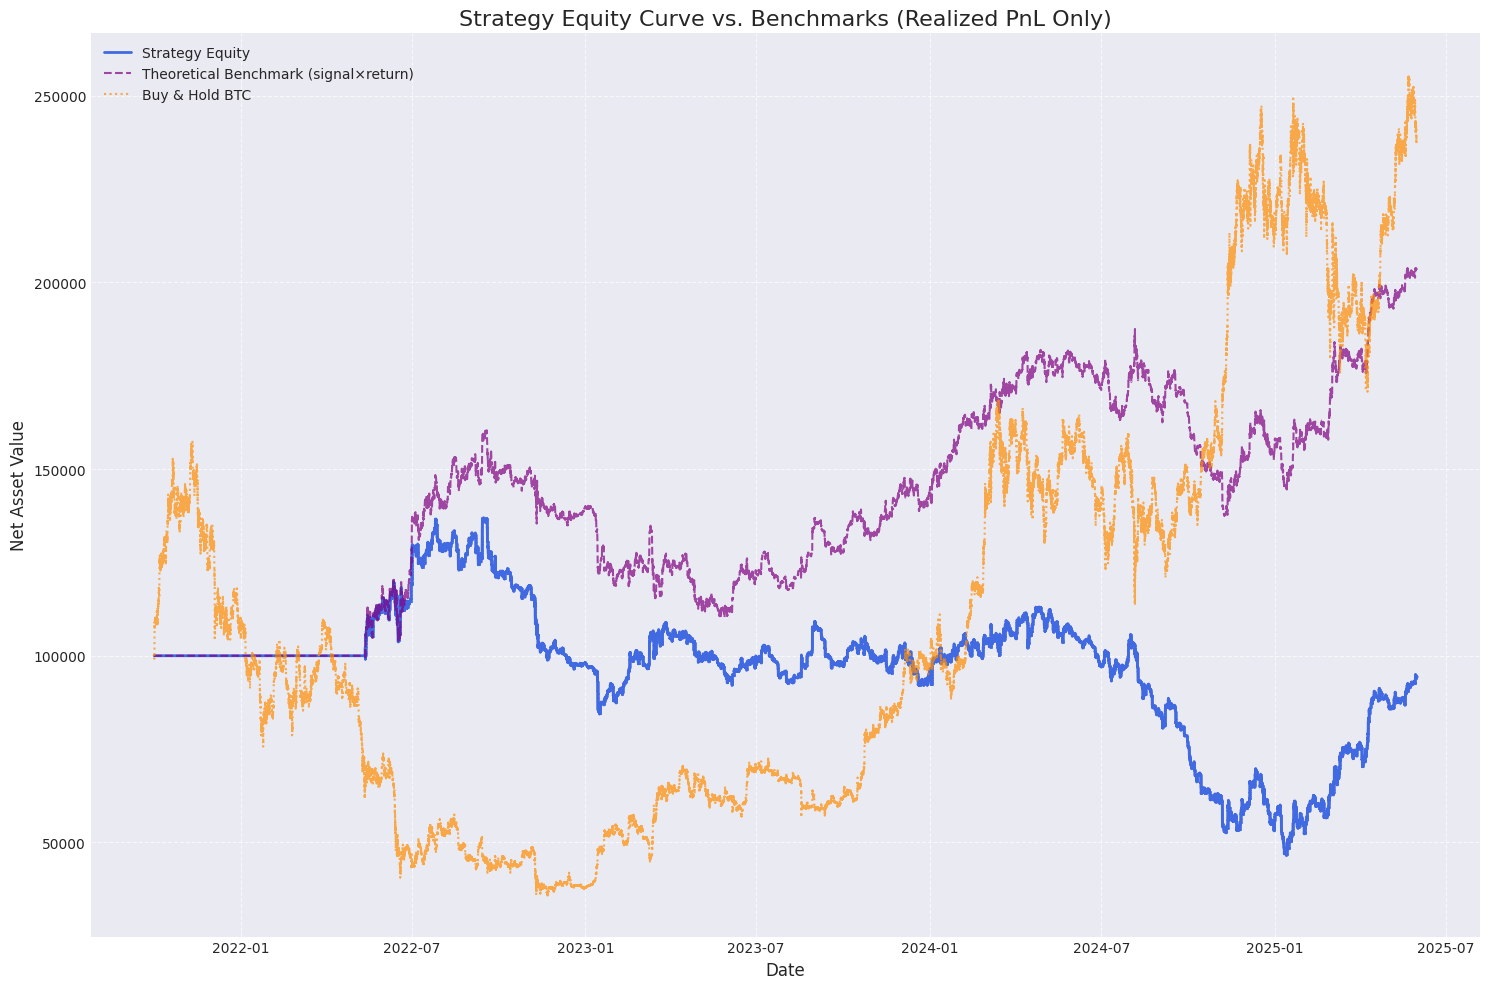

2025-08-08 00:59:32,575 - INFO - ✅ 策略评估报告生成完毕。


In [33]:
if __name__ == '__main__':
    # --- 0. CPU核心数配置 ---
    NUM_THREADS = 16
    tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
    tf.config.threading.set_inter_op_parallelism_threads(4)
    logging.info(f"🔧 TensorFlow已配置为使用最多 {NUM_THREADS} 个 intra-op 核心和 4 个 inter-op 核心。")

    # --- 1. 参数配置 ---
    FACTOR_FILE = '/public/data/factor_data/BTCUSDT_15m_2020_2025_factor_data.pkl'
    
    COMMISSION_RATE = 0.0002
    INITIAL_CAPITAL = 100000
    HOLDING_PERIOD = 10
    
    LOOKBACK_PERIOD = 60
    N_SPLITS = 5

    # --- 因子筛选流程配置 ---
    SCREENING_CONFIG = {
        # 回测参数
        'initial_capital': INITIAL_CAPITAL,
        'commission_rate': COMMISSION_RATE,
        'holding_period': HOLDING_PERIOD,
        
        # --- FIX: 添加 'rolling_window' 配置 ---
        # 阶段一: 质量指标阈值
        # 15分钟bar, 一天96个, 10天约960个bar, 作为一个合理的滚动窗口
        'rolling_window': 96 * 10, 
        'rank_ic_threshold': 0.01,
        'ir_threshold': 0.3,
        
        # 阶段二: 回测表现阈值
        'sharpe_threshold': 2.0,
        'calmar_threshold': 5.0,
        'expectancy_threshold': 0.25,
        'mdd_threshold': 0.20,
        'weekly_trades_threshold': 5
    }

    # --- 2. 加载因子数据 ---
    logging.info(f"📂 从 {FACTOR_FILE} 加载因子数据...")
    try:
        # 使用 with open 确保文件正确关闭
        with open(FACTOR_FILE, 'rb') as f:
            factor_data = pickle.load(f)
        factor_data.index = pd.to_datetime(factor_data.index)
        close_prices = factor_data['close'].copy()
        logging.info(f"✅ 数据加载成功 - 形状: {factor_data.shape}")
        logging.info(f"📅 时间范围: {factor_data.index[0]} 至 {factor_data.index[-1]}")
    except Exception as e:
        logging.error(f"❌ 加载数据时发生错误: {e}")
        factor_data = None

    # --- 3. 整合了因子筛选的完整逻辑流 (带回退机制) ---
    if factor_data is not None:
        # 3.1 执行两阶段因子筛选
        elite_factors, first_stage_factors = screen_factors_sequentially(factor_data, SCREENING_CONFIG)
        
        factors_for_model = []
        # 实现回退逻辑
        if elite_factors:
            logging.info(f"🎉 成功筛选出 {len(elite_factors)} 个精英因子，将用于模型训练。")
            factors_for_model = elite_factors
        elif first_stage_factors:
            logging.warning(f"⚠️ 未筛选出任何精英因子。回退使用通过第一阶段IC/IR初筛的 {len(first_stage_factors)} 个因子进行模型训练。")
            factors_for_model = first_stage_factors
        else:
            logging.error("❌ 没有任何因子能通过任何阶段的筛选，无法继续训练模型。请检查因子质量或大幅放宽筛选标准。")

        # 只有在有可用因子的情况下才继续
        if factors_for_model:
            logging.info(f"最终用于训练的因子列表 ({len(factors_for_model)}个): {factors_for_model}")
            try:
                # 3.2 使用选定的因子集准备数据
                X, y, indices, pca, selector = prepare_rolling_data(
                    factor_data, 
                    selected_features=factors_for_model, 
                    lookback=LOOKBACK_PERIOD
                )
                
                # 3.3 执行滚动训练并生成最终模型信号
                signals = rolling_train_and_predict(X, y, indices, lookback=LOOKBACK_PERIOD, n_splits=N_SPLITS)
                
                # 3.4 创建与原始数据对齐的完整信号序列
                full_signals = pd.Series(0, index=factor_data.index)
                full_signals.loc[signals.index] = signals
                
                # 3.5 对最终模型进行回测与评估
                logging.info("✅ 最终模型信号生成完毕，开始进行最终回测与评估...")
                
                backtest_results, trade_history = run_realized_pnl_backtest(
                    prices=close_prices,
                    signals=full_signals,
                    initial_capital=INITIAL_CAPITAL,
                    commission_rate=COMMISSION_RATE,
                    holding_period=HOLDING_PERIOD
                )

                evaluate_realized_pnl_performance(
                    backtest_results,
                    trade_history,
                    INITIAL_CAPITAL
                )
            except Exception as e:
                logging.error(f"❌ 在模型训练或最终回测过程中发生错误: {e}", exc_info=True)

    else:
        logging.warning("⚠️ 由于数据加载失败，跳过所有后续步骤。")